In [ ]:
from google.colab import drive
drive.mount('/content/drive')

image_folder = '/content/drive/MyDrive/Augmented_Balanced_Images/'
json_file = '/content/drive/MyDrive/Final Data with Encoded Labels.json'


Mounted at /content/drive


In [ ]:
import json
import os

with open(json_file, 'r') as f:
    data = json.load(f)

patient_data = []
label_mapping = {}
current_label = 0

for entry in data:
    image_files = entry.get('MRI', []) + entry.get('TAC', [])
    image_paths = [os.path.join(image_folder, f"{img}.png") for img in image_files]

    case_text = (
        f"Title: {entry['Case']['Title']}\n"
        f"History: {entry['Case'].get('History', '')}\n"
        f"Exam: {entry['Case'].get('Exam', '')}"
    )

    location = entry.get("Location", "Unknown")

    label = entry['Class/Label']
    if label not in label_mapping:
        label_mapping[label] = current_label
        current_label += 1
    numeric_label = label_mapping[label]

    patient_data.append({
        "images": image_paths,
        "text": case_text,
        "label": numeric_label,
        "location": location
    })
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(patient_data, test_size=0.2, random_state=42)

print(f"Training size: {len(train_data)}, Testing size: {len(test_data)}")


print(f"First entry: {patient_data[0]}")
print(f"Label mapping: {label_mapping}")


Training size: 4404, Testing size: 1101
First entry: {'images': ['/content/drive/MyDrive/Augmented_Balanced_Images/MPX1009_synpic46283.png', '/content/drive/MyDrive/Augmented_Balanced_Images/MPX1009_synpic46295.png'], 'text': 'Title: Bladder Diverticulum\nHistory: 73-year-old male with hematuria and numerous white blood cells found on UA\nExam: N/A', 'label': 0, 'location': 'Genitourinary'}
Label mapping: {0: 0, 11: 1, 7: 2, 8: 3, 4: 4, 1: 5, 2: 6, 9: 7, 5: 8, 6: 9, 3: 10, 10: 11}


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MultimodalDataset(Dataset):
    def __init__(self, data, tokenizer, transform):
        self.data = data
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        images = []
        for img_path in entry['images']:
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)
            images.append(image)

        if len(images) > 1:
            images = torch.stack(images)
            images = torch.mean(images, dim=0)
        elif len(images) == 1:
            images = images[0]
        else:
            images = torch.zeros((3, 224, 224))

        tokens = self.tokenizer(
            entry["text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt"
        )

        label = torch.tensor(entry["label"], dtype=torch.long)

        return images, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0), label


Using device: cuda


In [ ]:
import torch.nn as nn
from torchvision import models
from transformers import DistilBertModel

class MultimodalModel(nn.Module):
    def __init__(self, text_model, image_model, text_embedding_size, image_embedding_size, num_classes=12):
        super(MultimodalModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model

        self.image_fc = nn.Linear(image_embedding_size, 256)

        self.fc1 = nn.Linear(256 + text_embedding_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, images, input_ids, attention_mask):

        image_features = self.image_model(images)
        image_features = self.image_fc(image_features)


        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]


        combined = torch.cat((image_features, text_features), dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [ ]:
from transformers import DistilBertTokenizer
from torchvision import transforms
from torch.utils.data import DataLoader

image_model = models.resnet50(pretrained=True)
image_model.fc = nn.Identity()
text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MultimodalDataset(data=train_data, tokenizer=tokenizer, transform=transform)
test_dataset = MultimodalDataset(data=test_data, tokenizer=tokenizer, transform=transform)


train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True
)


dataset = MultimodalDataset(patient_data, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

multimodal_model = MultimodalModel(
    text_model=text_model,
    image_model=image_model,
    text_embedding_size=768,
    image_embedding_size=2048,
    num_classes=12
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, 

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 5

for epoch in range(epochs):
    multimodal_model.train()
    running_loss = 0.0
    i = 0
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, input_ids, attention_masks)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
        i += 1

        if batch_idx % 100 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}_batch_{batch_idx}.pth")
            torch.save({
                'epoch': epoch,
                'batch_idx': batch_idx,
                'model_state_dict': multimodal_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}")

    torch.save(multimodal_model.state_dict(), os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth"))
    print(f"Model saved for epoch {epoch+1}")


Epoch 1, Batch 1/276, Loss: 2.4525
Checkpoint saved at /content/drive/MyDrive/checkpoints/checkpoint_epoch_1_batch_0.pth
Epoch 1, Batch 2/276, Loss: 2.4203
Epoch 1, Batch 3/276, Loss: 2.4281
Epoch 1, Batch 4/276, Loss: 2.4845
Epoch 1, Batch 5/276, Loss: 2.5000
Epoch 1, Batch 6/276, Loss: 2.4613
Epoch 1, Batch 7/276, Loss: 2.4803
Epoch 1, Batch 8/276, Loss: 2.5266
Epoch 1, Batch 9/276, Loss: 2.4668
Epoch 1, Batch 10/276, Loss: 2.4326
Epoch 1, Batch 11/276, Loss: 2.4232
Epoch 1, Batch 12/276, Loss: 2.4484
Epoch 1, Batch 13/276, Loss: 2.4297
Epoch 1, Batch 14/276, Loss: 2.4213
Epoch 1, Batch 15/276, Loss: 2.5355
Epoch 1, Batch 16/276, Loss: 2.3798
Epoch 1, Batch 17/276, Loss: 2.4629
Epoch 1, Batch 18/276, Loss: 2.6061
Epoch 1, Batch 19/276, Loss: 2.5737
Epoch 1, Batch 20/276, Loss: 2.4200
Epoch 1, Batch 21/276, Loss: 2.4412
Epoch 1, Batch 22/276, Loss: 2.4399
Epoch 1, Batch 23/276, Loss: 2.3967
Epoch 1, Batch 24/276, Loss: 2.4458
Epoch 1, Batch 25/276, Loss: 2.4366
Epoch 1, Batch 26/276, 

KeyboardInterrupt: 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
Test Loss: 0.2560
Test Accuracy: 94.46%


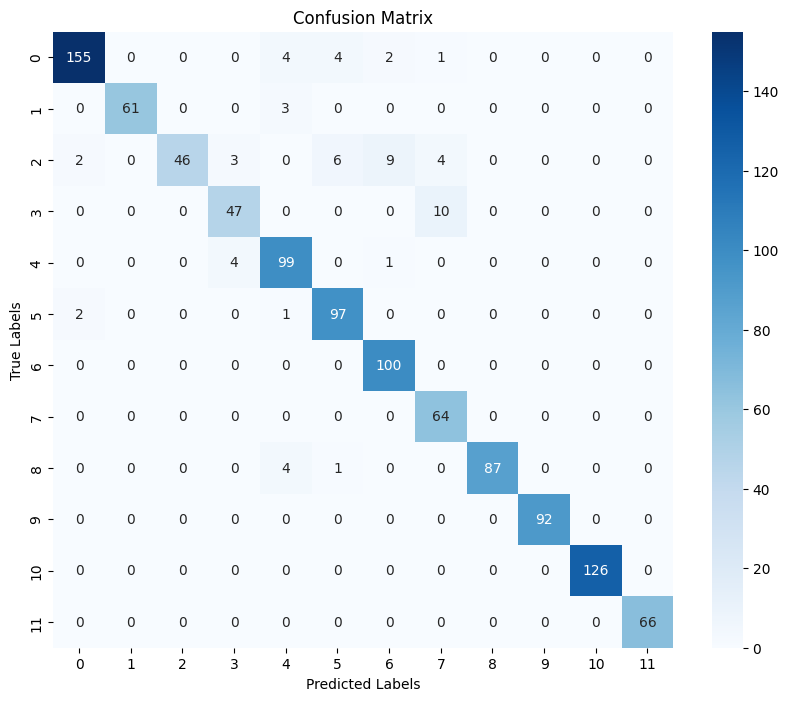


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95       166
     Class 1       1.00      0.95      0.98        64
     Class 2       1.00      0.66      0.79        70
     Class 3       0.87      0.82      0.85        57
     Class 4       0.89      0.95      0.92       104
     Class 5       0.90      0.97      0.93       100
     Class 6       0.89      1.00      0.94       100
     Class 7       0.81      1.00      0.90        64
     Class 8       1.00      0.95      0.97        92
     Class 9       1.00      1.00      1.00        92
    Class 10       1.00      1.00      1.00       126
    Class 11       1.00      1.00      1.00        66

    accuracy                           0.94      1101
   macro avg       0.94      0.94      0.94      1101
weighted avg       0.95      0.94      0.94      1101



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

multimodal_model.eval()


correct = 0
total = 0
test_loss = 0.0


all_labels = []
all_predictions = []
i=1
with torch.no_grad():
    for images, input_ids, attention_masks, labels in test_dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, input_ids, attention_masks)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        print(i)
        i+=1

accuracy = 100 * correct / total
average_loss = test_loss / len(test_dataloader)

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(12), yticklabels=range(12))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(12)]))


In [ ]:
train_correct = 0
train_total = 0

multimodal_model.eval()

with torch.no_grad():
    for images, input_ids, attention_masks, labels in train_dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, input_ids, attention_masks)

        _, predicted = torch.max(outputs, 1)

        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy = 100 * train_correct / train_total
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 93.89%
